Hi. I am the new kaggler. Despite the task that we are required to track the vaccination progress of each countries, I am curious regarding what vaccines brands are using by each countries. There are several brands to choose but what makes the governments to choose those particular brands? Let see the popularity and distribution of each vaccine brands in the world.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
import plotly.express as px
import geopandas as gpd

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
dataFrame = pd.read_csv("/kaggle/input/covid-world-vaccination-progress/country_vaccinations.csv")
dataFrame

Let us see what vaccine is the most popular.
We can observe that most of the countries uses combination of vaccines for a reason.

In [ ]:
vaccine_used = pd.unique(dataFrame['vaccines'])
print(vaccine_used)
vaccine_used.shape

I want to check the total usage of each vaccines brands based on daily_vaccinations. Therefore, the null values will be replaced by zero. Filling up the missing data can be done by inserting mean/ min/ max of daily vaccination, but I have to separate each and every country because the standard deviation is too large.
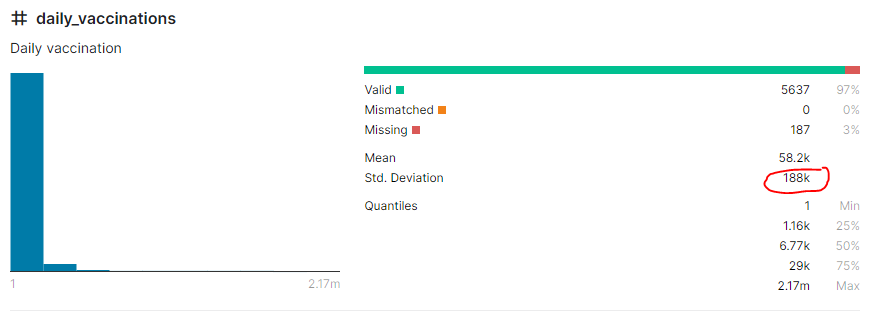

In [ ]:
dataFrame['daily_vaccinations'] = dataFrame['daily_vaccinations'].replace(np.nan, 0)

Let's get the total count of the vaccine usage.

In [ ]:
vaccine_manufacturer = dict()

def get_vac_count(data):
    # split the data if multiple vaccines used
    vacs = data['vaccines'].split(", ")
    
    # update the vaccines dictionary
    for vac in vacs:
        if vac in vaccine_manufacturer.keys():
            vaccine_manufacturer[vac] += data['daily_vaccinations']    
        else:
            vaccine_manufacturer[vac] = 0

dataFrame[['daily_vaccinations','vaccines']].apply(get_vac_count, axis=1)

sorted_vaccine_popularity = dict(sorted(vaccine_manufacturer.items(), key = lambda item: item[1], reverse=True))
sorted_vaccine_popularity

Let visualize it

In [ ]:
chart = plt.figure()
ax = chart.add_axes([-0.5,-0.1,2,1])
ax.bar(sorted_vaccine_popularity.keys(), sorted_vaccine_popularity.values())
plt.xticks(rotation=90)
chart.suptitle('Popularity of Vaccine Brands based on Daily Vaccinations')
plt.show()

# Visualization with geopandas
## Vaccine Brand Distribution in The World

We know from above that some countries uses more than one vaccine brands. I would like to know the distribution of each vaccine brands in the entire world. Theerefore, I have to separate them and plot them one by one.

In [ ]:
country_vac_df = dataFrame[['country', 'iso_code','vaccines']]
temp_filter_mask = country_vac_df.duplicated()
filter_mask = [not index for index in temp_filter_mask]
unique_country_vac_df = country_vac_df[filter_mask]
unique_country_vac_df

In [ ]:
unique_country_vac_list = []

def transform_vacs_to_vac(data):
    # If the country uses only one type of vaccine brand, directly insert to new dataframe.
    # Else split them and insert to new dataframe separately
    
    if "," in data['vaccines']:
        vacs = data['vaccines'].split(", ")
        
        for vac in vacs:
            temp = {'country': data['country'], 'iso_code': data['iso_code'], 'vaccines': vac}
            unique_country_vac_list.append(temp)
    else:
        temp = {'country': data['country'], 'iso_code': data['iso_code'], 'vaccines': data['vaccines']}
        unique_country_vac_list.append(temp)
    
for index, row in unique_country_vac_df.iterrows():
    transform_vacs_to_vac(row)

unique_country_vac_df2 = pd.DataFrame(unique_country_vac_list)
unique_country_vac_df2.tail(10)

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
vaccines_list = list(unique_country_vac_df2['vaccines'].unique())

def one_vac_per_country(data, vac_name):
    for index, row in unique_country_vac_df2.iterrows():
        if data['iso_a3'] == row['iso_code'] and row['vaccines'] == vac_name:
            return vac_name

for i in range(len(vaccines_list)):
    world_copy = world.copy()
    world_copy['vaccines'] = world_copy.apply(lambda row: one_vac_per_country(row, vaccines_list[i]), axis=1)
    world_copy.plot(column='vaccines', legend=True, figsize=(15, 10), missing_kwds={
    "color": "lightgrey",
    "label": "Other Brands",
})

So, my concerns are:
1. What factors affect the selection of vaccine brands for them (effectiveness and cost tradeoff)?
2. What are the differences between those vaccines (stability of vaccines, side effects)?

What is your opinions? Share with me :)